### Loading libraries

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns

from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler

In [108]:
# Проверка доступности GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


### Loading data

In [109]:
close = pd.read_csv('close.csv', index_col='time')
close.index = pd.to_datetime(close.index)
close.ffill(inplace=True)

open = pd.read_csv('open.csv', index_col='time')
open.index = pd.to_datetime(open.index)
open.ffill(inplace=True)

high = pd.read_csv('high.csv', index_col='time')
high.index = pd.to_datetime(high.index)
high.ffill(inplace=True)

low = pd.read_csv('low.csv', index_col='time')
low.index = pd.to_datetime(low.index)
low.ffill(inplace=True)

value = pd.read_csv('value.csv', index_col='time')
value.index = pd.to_datetime(value.index)
value.ffill(inplace=True)

volume = pd.read_csv('volume.csv', index_col='time')
volume.index = pd.to_datetime(volume.index)
volume.ffill(inplace=True)

In [110]:
# close = pd.read_csv('data/hour/close.csv', index_col='Time')
# opens = pd.read_csv('data/hour/opens.csv', index_col='Time')
# high = pd.read_csv('data/hour/high.csv', index_col='Time')
# low = pd.read_csv('data/hour/low.csv', index_col='Time')
# volume = pd.read_csv('data/hour/volume.csv', index_col='Time')

# close_h = pd.read_csv('data/half/close_h.csv', index_col='Time')
# opens_h = pd.read_csv('data/half/open_h.csv', index_col='Time')
# high_h = pd.read_csv('data/half/high_h.csv', index_col='Time')
# low_h = pd.read_csv('data/half/low_h.csv', index_col='Time')
# volume_h = pd.read_csv('data/half/volume_h.csv', index_col='Time')

In [111]:
data = {
  'close': close,
  'opens': open,
  'high': high,
  'low': low,
  'value': value,
  'volume': volume
}

# half_data = {
#   'close_h': close_h,
#   'opens_h': opens_h,
#   'high_h': high_h,
#   'low_h': low_h,
#   'volume_h': volume_h,
# }

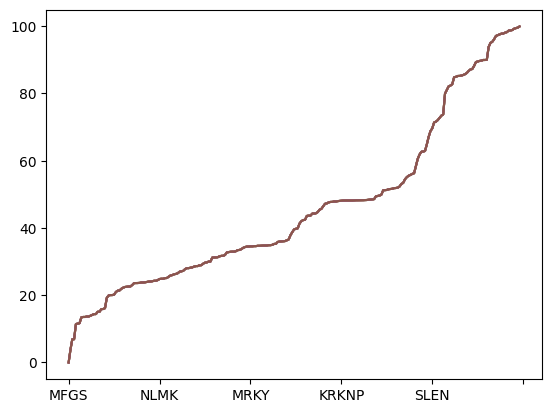

In [112]:
for df in data:
  missing_values = data[df]
  missing_values = close.isnull().sum()
  missing_percent = missing_values / len(close) * 100
  missing_percent.sort_values().plot()
plt.show()

# for df in half_data:
#   missing_values = half_data[df]
#   missing_values = close.isnull().sum()
#   missing_percent = missing_values / len(close) * 100
#   missing_percent.sort_values().plot()
# plt.show()

In [113]:
good_columns = close.ffill().interpolate(method='linear').isna().sum()[close.ffill().interpolate(method='linear').isna().sum() < 2000].index

In [114]:
close = close[good_columns].ffill().interpolate(method='linear').dropna()
open = open[good_columns].ffill().interpolate(method='linear').dropna()
high = high[good_columns].ffill().interpolate(method='linear').dropna()
low = low[good_columns].ffill().interpolate(method='linear').dropna()
volume = volume[good_columns].ffill().interpolate(method='linear').dropna()

returns = close.pct_change().dropna()

close.columns = [f'close_{col}' for col in close.columns]
open.columns = [f'open_{col}' for col in open.columns]
high.columns = [f'high_{col}' for col in high.columns]
low.columns = [f'low_{col}' for col in low.columns]
volume.columns = [f'volume_{col}' for col in volume.columns]

In [115]:
returns = close.pct_change().dropna()

In [116]:
training_data = pd.concat([
  close,
  open,
  high,
  low,
  volume
], axis=1)

In [117]:
x = training_data.iloc[1:-1].values
y = training_data.iloc[:,0].pct_change().shift().dropna().values

x, x_final = x[:-100], x[-100:]
y, y_final = y[:-100], y[-100:]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

### Making ML model

#### single instrument LSTM

##### setting up model

In [118]:
class TimeSeriesNumpyDataset(Dataset):
  def __init__(self, x_data, y_data):
    self.x_data = torch.tensor(x_data, dtype=torch.float32)
    self.y_data = torch.tensor(y_data, dtype=torch.float32)

  def __len__(self):
    return len(self.x_data)

  def __getitem__(self, index):
    return self.x_data[index], self.y_data[index]

# Создание Dataset для тренировочных и тестовых данных
train_dataset = TimeSeriesNumpyDataset(x_train, y_train)
test_dataset = TimeSeriesNumpyDataset(x_test, y_test)
final_dataset = TimeSeriesNumpyDataset(x_final, y_final)

# Создание DataLoader для тренировочных и тестовых данных
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
final_loader = DataLoader(final_dataset, batch_size=32, shuffle=False)

In [119]:
class LSTMModel(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers=1):
    super(LSTMModel, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
    c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
    out, _ = self.lstm(x, (h_0, c_0))
    out = self.fc(out[:, -1, :])
    return out

# Параметры модели
input_size = x_train.shape[1]  # Количество признаков (features)
hidden_size = 50
output_size = 1  # Поскольку y_train это вектор, выход будет одномерным
num_layers = 1

model = LSTMModel(input_size, hidden_size, output_size, num_layers)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

##### Learning ML model

In [120]:
# Перенос модели на GPU
model = model.to(device)

# Обучение модели на GPU
num_epochs = 5* 10 ** 2
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        x_batch = x_batch.unsqueeze(1)  # Преобразуем в форму (batch_size, 1, features)
        optimizer.zero_grad()
        y_pred = model(x_batch)
        y_batch = y_batch.unsqueeze(1)  # Преобразуем в форму (batch_size, 1)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    epoch_loss /= len(train_loader)
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {epoch_loss}')
        train_losses.append(epoch_loss)
    
    # Оценка модели на тестовых данных
    model.eval()
    test_epoch_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            x_batch = x_batch.unsqueeze(1)  # Преобразуем в форму (batch_size, 1, features)
            y_pred = model(x_batch)
            y_batch = y_batch.unsqueeze(1)  # Преобразуем в форму (batch_size, 1)
            loss = criterion(y_pred, y_batch)
            test_epoch_loss += loss.item()
    test_epoch_loss /= len(test_loader)
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Test Loss: {test_epoch_loss}')
        test_losses.append(test_epoch_loss)

Epoch 0, Train Loss: 0.040094616550086726
Epoch 0, Test Loss: 0.030466000735759734
Epoch 10, Train Loss: 0.019327054129480714
Epoch 10, Test Loss: 0.019599186442792415
Epoch 20, Train Loss: 0.018904130379057894
Epoch 20, Test Loss: 0.019091497510671615
Epoch 30, Train Loss: 0.01890544814405718
Epoch 30, Test Loss: 0.019504992067813875
Epoch 40, Train Loss: 0.018637857719729044
Epoch 40, Test Loss: 0.019544366747140884
Epoch 50, Train Loss: 0.018683981385571185
Epoch 50, Test Loss: 0.01894718561321497
Epoch 60, Train Loss: 0.018821341446553817
Epoch 60, Test Loss: 0.019104966968297957
Epoch 70, Train Loss: 0.01869017065436852
Epoch 70, Test Loss: 0.019537396915256976
Epoch 80, Train Loss: 0.01866215665947006
Epoch 80, Test Loss: 0.019055092111229896
Epoch 90, Train Loss: 0.018864724897977077
Epoch 90, Test Loss: 0.01890617549419403
Epoch 100, Train Loss: 0.01868450136460138
Epoch 100, Test Loss: 0.01908417697995901
Epoch 110, Train Loss: 0.018655490101964184
Epoch 110, Test Loss: 0.0195

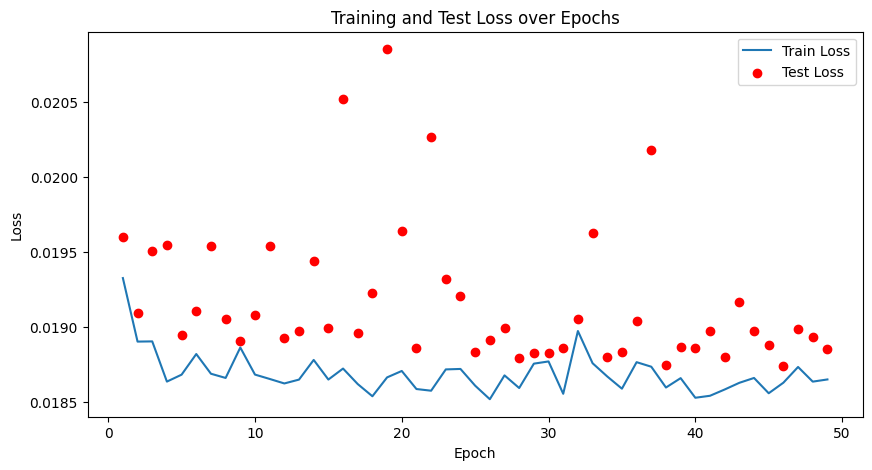

In [121]:
# Построение графика
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs // 10)[1:], train_losses[1:], label='Train Loss')
plt.scatter(range(num_epochs // 10)[1:], test_losses[1:], color='r', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.show()

##### testing model

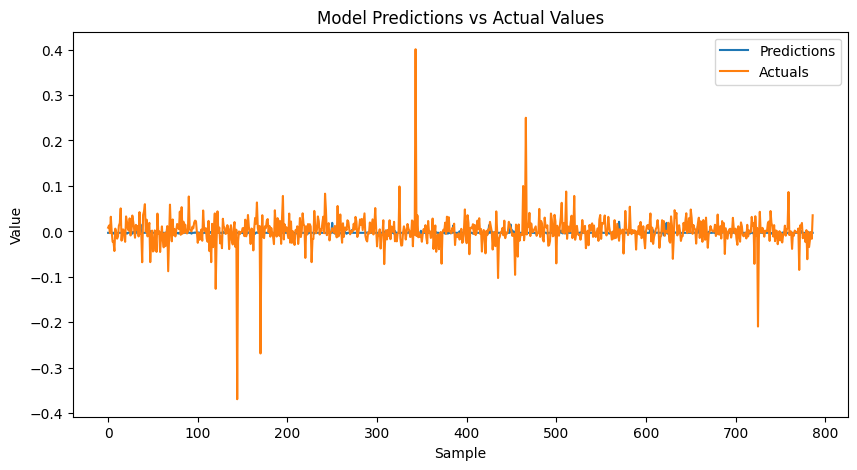

In [122]:
# Получение предсказаний модели на тестовом наборе
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        x_batch = x_batch.unsqueeze(1)  # Преобразуем в форму (batch_size, 1, features)
        y_pred = model(x_batch)
        predictions.append(y_pred.cpu().numpy())  # Переносим предсказания на CPU и в numpy
        actuals.append(y_batch.cpu().numpy())  # Переносим реальные значения на CPU и в numpy

# Преобразуем списки в numpy массивы
predictions = np.concatenate(predictions, axis=0)
actuals = np.concatenate(actuals, axis=0)

# Вывод первых 10 предсказаний и соответствующих реальных значений
# print("Predictions: ", predictions[:10])
# print("Actuals: ", actuals[:10])

# Построение графика для сравнения предсказаний и реальных значений
plt.figure(figsize=(10, 5))
plt.plot(predictions, label='Predictions')
plt.plot(actuals, label='Actuals')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Model Predictions vs Actual Values')
plt.legend()
plt.show()

<Axes: xlabel='time'>

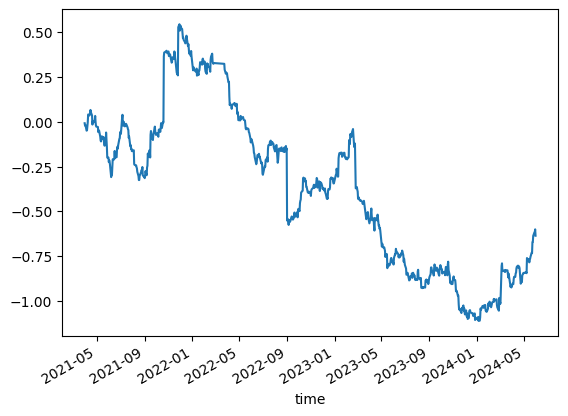

In [123]:
res = pd.DataFrame({
  'actual': actuals,
  'pred': predictions.reshape(predictions.shape[0])
}, index=training_data.index[-predictions.shape[0]:])

alpha = np.where(res['pred'] > 0, 1, -1)
(alpha * res['actual']).cumsum().plot()

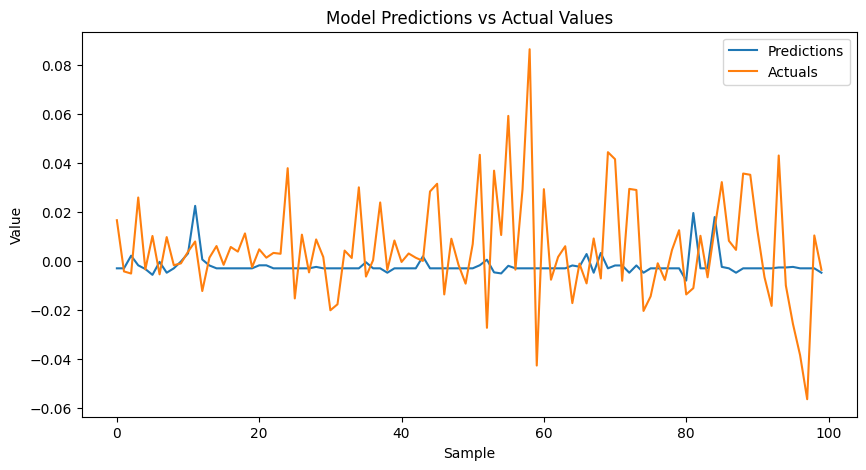

In [124]:
# Получение предсказаний модели на тестовом наборе
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for x_batch, y_batch in final_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        x_batch = x_batch.unsqueeze(1)  # Преобразуем в форму (batch_size, 1, features)
        y_pred = model(x_batch)
        predictions.append(y_pred.cpu().numpy())  # Переносим предсказания на CPU и в numpy
        actuals.append(y_batch.cpu().numpy())  # Переносим реальные значения на CPU и в numpy

# Преобразуем списки в numpy массивы
predictions = np.concatenate(predictions, axis=0)
actuals = np.concatenate(actuals, axis=0)

# Вывод первых 10 предсказаний и соответствующих реальных значений
# print("Predictions: ", predictions[:10])
# print("Actuals: ", actuals[:10])

# Построение графика для сравнения предсказаний и реальных значений
plt.figure(figsize=(10, 5))
plt.plot(predictions, label='Predictions')
plt.plot(actuals, label='Actuals')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Model Predictions vs Actual Values')
plt.legend()
plt.show()

<Axes: xlabel='time'>

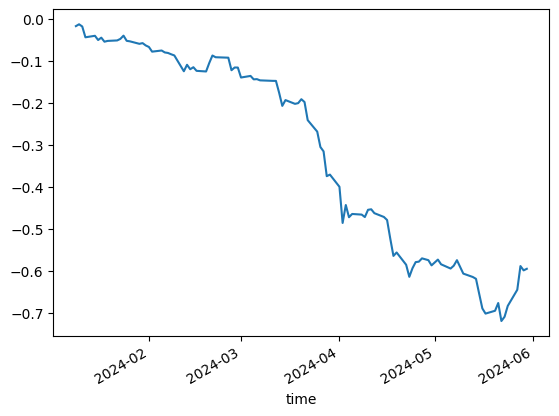

In [125]:
final = pd.DataFrame({
  'actual': actuals,
  'pred': predictions.reshape(predictions.shape[0])
}, index=training_data.index[-predictions.shape[0]:])

alpha = np.where(final['pred'] > 0, 1, -1)
(alpha * final['actual']).cumsum().plot()

#### multi instrument model

In [127]:
close_columns = []
for col in good_columns:
  close_columns.append(f'close_{col}')

In [189]:
target = training_data[close_columns].pct_change().ffill().dropna()
target = target.replace(np.inf, 0).replace(-np.inf, 0)

training_data

,close_AFKS,close_AFLT,close_AKRN,close_APTK,close_ARSA,close_ASSB,close_BSPB,close_CHMF,close_DVEC,close_GAZP,...,volume_VLHZ,volume_VRSB,volume_VRSBP,volume_VSMO,volume_VTBR,volume_WTCM,volume_WTCMP,volume_YKEN,volume_YRSB,volume_YRSBP
time,,,,,,,,,,,,,,,,,,,,,
2008-04-18,32.385,103.25,2084.99,1046.000,5.790,0.645,122.00,616.80,1.634,317.33,...,600.0,1100.0,300.0,1450.0,5.934936e+10,10100.0,12200.0,1184500.0,6500.0,102500.0
2008-04-21,32.450,103.00,2089.96,1005.000,5.298,0.643,123.00,608.00,1.621,314.24,...,200.0,1500.0,100.0,383.0,3.222814e+10,16700.0,7900.0,2615000.0,1600.0,48700.0
2008-04-22,31.984,100.85,2080.00,990.000,5.184,0.637,125.00,611.25,1.648,314.10,...,200.0,1500.0,100.0,253.0,1.686705e+10,1100.0,100.0,1711800.0,300.0,48700.0
2008-04-23,31.656,101.00,2187.00,982.000,4.399,0.643,126.00,603.00,1.635,315.50,...,100.0,11800.0,800.0,805.0,2.446028e+10,700.0,500.0,266500.0,400.0,80200.0
2008-04-24,31.620,101.36,2138.00,969.000,6.080,0.637,122.50,590.00,1.620,311.40,...,100.0,2100.0,15000.0,769.0,3.233204e+10,700.0,500.0,1394100.0,6000.0,50000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-24,27.655,58.13,16290.00,12.578,15.310,2.830,368.60,1990.80,3.118,133.34,...,6110.0,29910.0,7690.0,1088.0,2.299558e+11,67800.0,63000.0,4800000.0,340.0,2380.0
2024-05-27,26.091,55.08,16148.00,12.370,15.000,2.730,357.34,1942.60,2.900,128.42,...,7190.0,22830.0,6880.0,3101.0,3.967705e+11,61300.0,61100.0,1890000.0,420.0,2090.0
2024-05-28,26.359,55.82,16290.00,12.722,15.130,2.755,364.88,1887.60,2.920,128.47,...,7450.0,16440.0,5080.0,1698.0,2.027834e+11,85000.0,68700.0,1110000.0,250.0,4240.0
